In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import librosa.display
import python_speech_features as psf

['hungry', 'awake', 'uncomfortable', 'hug', 'diaper', 'sleepy']
(16000, array([  0,  -1,   5, ..., 904, 678, 220], dtype=int16))
[160, 160, 160, 160, 134, 144]


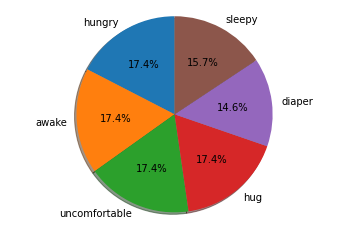

In [2]:
path = "data/train"
classes = os.listdir(path)
print(classes)
print (wavfile.read("data/train/awake/awake_0.wav"))
classe_num = [0]*len(classes)

i = 0
while i < len(classes) :
    classe_num[i] = len(os.listdir(path+"/"+classes[i]))
    i += 1
print(classe_num)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:


fig1, ax1 = plt.subplots()
ax1.pie(classe_num, labels=classes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


[ 1600. 16000. 44100.]
[712, 198, 8]


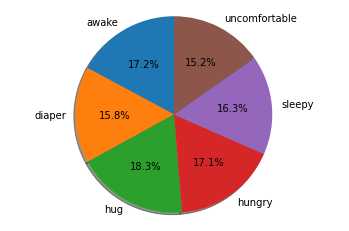

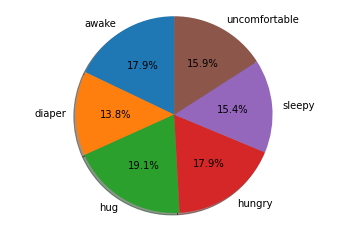

In [3]:
df = pd.DataFrame()
f=0
for c in classes:
    i = 0 
    while i < len(os.listdir(path+"/"+c)):
        rate, signal = wavfile.read(path + "/" + c + "/" + c + "_" + str(i) + ".wav")
        df.at[f, 'length'] = signal.shape[0] / rate
        df.at[f, 'label'] = c
        df.at[f, 'sample_rate'] = rate
        #length.append (signal.shape[0] / rate)
        i += 1
        f += 1
#print(df)

#find out what are the sample rates used
rate_list = np.unique(df.sample_rate)
print(rate_list)
rates = df["sample_rate"].value_counts()
print(rates.tolist())

class_dist = df.groupby(['label'])['length'].mean()
total_length = df.groupby(['label'])['length'].sum()
#print(total_length)
classes = sorted(classes, key=str.lower)

#plot average length of audio for each class
fig1, ax1 = plt.subplots()
ax1.pie(class_dist, labels=classes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

#plot total length of audio for each class
fig1, ax1 = plt.subplots()
ax1.pie(total_length, labels=classes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()



Data Preprocessing

In [4]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask
    
def plot_signal (signal, title):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False,sharey=True, figsize=(20,5))
    fig.suptitle(title, size=16)
    i = 0
    for x in range(2):
        for y in range(3):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def plot_mfccs (mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False,sharey=True, figsize=(20,5))
    fig.suptitle("MFCC", size=16)
    i = 0
    for x in range(2):
        for y in range(3):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap = 'hot', interpolation = 'nearest')
            #librosa.display.specshow(list(mfccs.values())[i], x_axis='time')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
            
def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return(Y,freq)

(26, 87)
(26, 99)
(13, 99)
(26, 87)
(26, 99)
(13, 99)
(26, 87)
(26, 99)
(13, 99)
(26, 87)
(26, 99)
(13, 99)
(26, 87)
(26, 99)
(13, 99)
(26, 87)
(26, 99)
(13, 99)


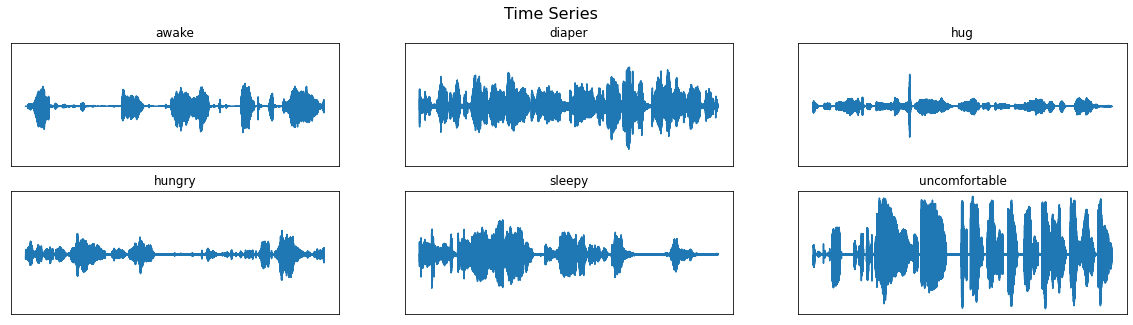

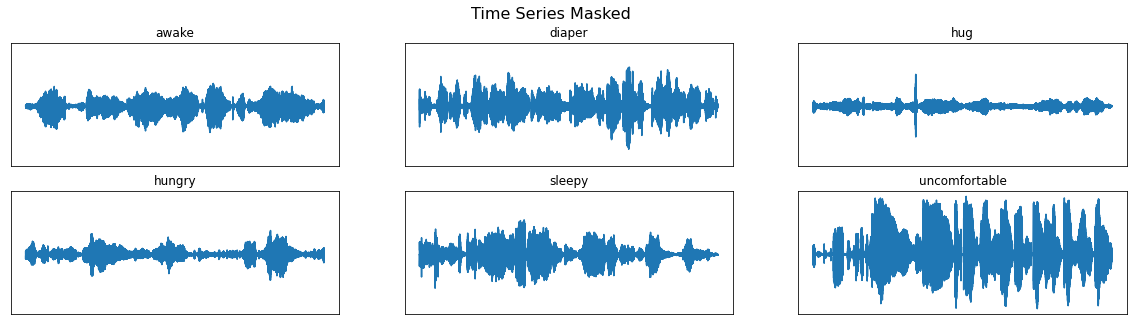

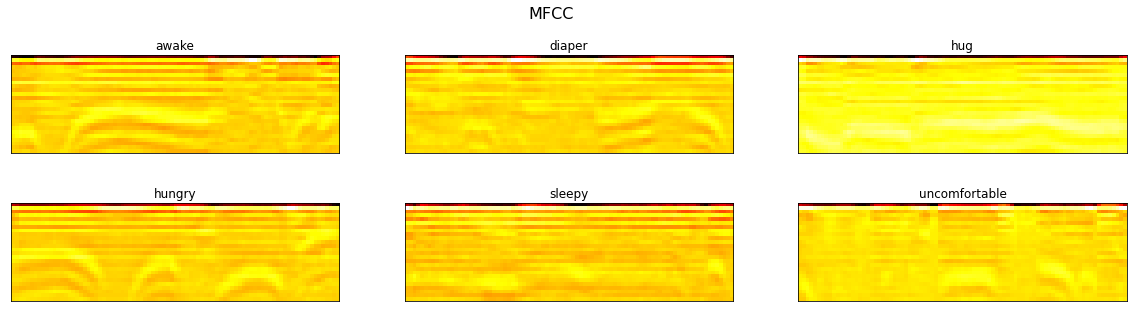

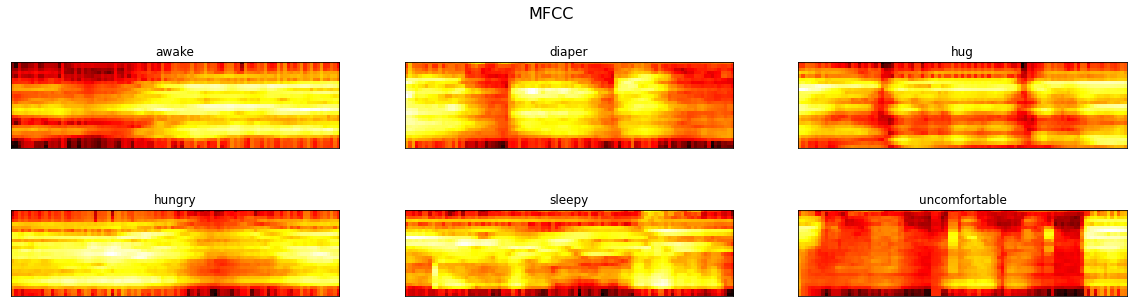

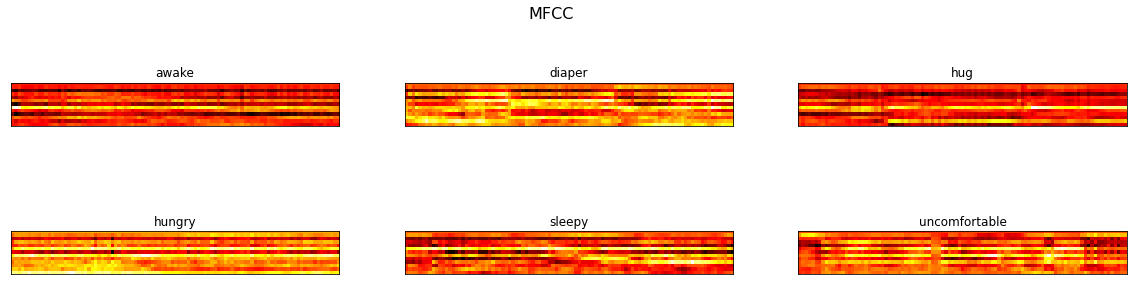

In [7]:
#plot time series


signals = {}
masked_signals = {}
mfccs = {}

fft = {}
fbank ={}
mfcc_test = {}
for c in classes:
    file_name ="/" + c + "/" + c + "_9.wav"
    signal, rate = librosa.load("data/train/"+file_name)
    mask = envelope(signal, rate, 0.005)
    
    signal_masked = signal[mask]
    
    
    #mfcc = librosa.feature.mfcc(y = signal[:rate], sr = rate, n_mfcc=40)
    mfcc00 = librosa.feature.mfcc(y = signal_masked[:2*rate], sr = rate, n_mfcc=26)
    print(mfcc00.shape)
    signals[c] = signal
    masked_signals[c] = signal_masked
    mfccs[c] = mfcc00

    fft[c] = calc_fft(signal, rate)
    bank = psf.logfbank(signal_masked[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    print(bank.shape)
    mel = psf.mfcc(signal_masked[:rate], rate, numcep = 13, nfilt=26, nfft=1103).T
    mfcc_test[c] = mel
    print(mel.shape)
    

plot_signal(signals, "Time Series")
plt.show()

plot_signal(masked_signals, "Time Series Masked")
plt.show()

plot_mfccs(mfccs)
plt.show()

plot_mfccs(fbank)
plt.show()

plot_mfccs(mfcc_test)
plt.show()


Export Data

In [117]:
if len(os.listdir('data/clean')) == 0:
    for c in classes:
        print(c)
        i=0
        while i < len(os.listdir(path+"/"+c)):
            file_path = "data/train/" + c + "/" + c + "_" + str(i) + ".wav"
            signal, rate = librosa.load(file_path, sr=16000)
            mask = envelope(signal, rate, 0.005)
            data = signal[mask]
            
            if len(signal[mask])/rate > 1:
                wavfile.write(filename = "data/clean/"+ c + "_" + str(i) + ".wav",rate = rate, data = data)
            else:
                print(str(file_path)+"is empty")
                
            i += 1
    

hungry
awake
data/train/awake/awake_61.wavis empty
data/train/awake/awake_87.wavis empty
data/train/awake/awake_133.wavis empty
uncomfortable
data/train/uncomfortable/uncomfortable_0.wavis empty
hug
diaper
sleepy
